In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import BasicFunctions as SGf
from core.spectragen import SOGM
from core.spectrapad import padspectra as PS
import core.wetspectra.waterU as WW
import matplotlib.cm as cm
from scipy.signal import savgol_filter
import models.prosail.prosailmodel as prosail

# Generate soil spectra

(0.0, 50.0)

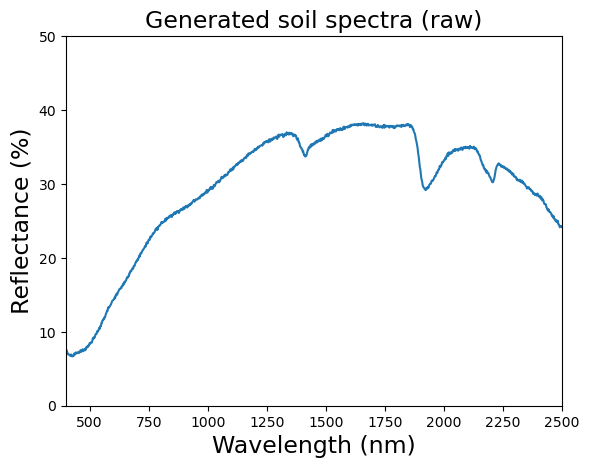

In [32]:
# define wavelength range
wavelength = np.arange(400,2500,1)
prop_test_1 = []
# set soil properties (-1 means not available)
spectrabrand = 'FOSS'  # ASD, FOSS, Spectral Evolution, or None
Clay = 8   # %
Silt = 7   # %   
# Sand content is calculated by 100 - Clay - Silt
SOM = 120  # soil organic matter, g/kg
Nitrogen = 2.2  # total nitrogen content, g/kg
CEC = 123 # cation exchange capacity, cmol(+)/kg
OC = 38 # organic carbon content, g/kg
tP = -1 # total phosphorus content, mg/kg
pH_w = 4.7 # pH measured from water solution
Fe = 80000 # iron content, mg/kg
dens = -1 # soil bulk density, g/cm3
ec = -1 # electrical conductivity, mS/m
caco3 = -1 # CaCO3 content, g/kg
tc = -1 # total carbon content, %

prop_test_1.append(SGf.setProp(spectrabrand, Clay, Silt, SOM, Nitrogen, CEC, OC, tP, pH_w, Fe, dens, ec, caco3, tc))
emb_test = SGf.words2indices(prop_test_1, 42, 16, 509)
# average 5 times
emb_test = emb_test.repeat(5,1,1)
 # change to 'cuda' if GPU is available; # True for identical random seed for multiple spectra
spectratest = SOGM.generatespectra(emb_test, torch.device('cpu'), False)
spectratest = np.mean(spectratest,0) # get mean of 5 spectra
spectratest = spectratest.reshape(1,-1)

# store x and y in xml file in Helios spectra format
spectra_ = []
for i in range(1):
    spectra_.append((wavelength, spectratest[i, :].T, f"Generated soil reflectivity {i}"))
# save_multiple_spectra_to_xml(spectra_, "results/New soil 0.xml")

plt.plot(wavelength,100*spectratest[:, :].T)
x_limit = (400, 2500)
y_limit = (0, 50)
x_label = 'Wavelength (nm)'
y_label = 'Reflectance (%)'
fontsz = 17
plt.title('Generated soil spectra (raw)', fontsize=fontsz)
plt.xlabel(x_label, fontsize=fontsz)
plt.ylabel(y_label, fontsize=fontsz)
plt.xlim(x_limit)
plt.ylim(y_limit)

# Smooth spectratest using Savitzky-Golay 2nd order filter if needed

(0.0, 50.0)

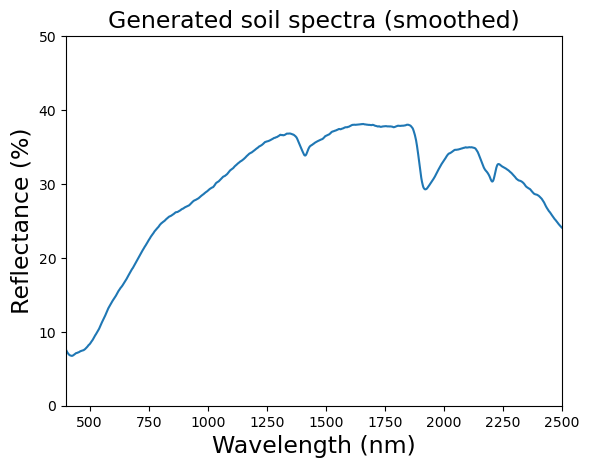

In [33]:
spectratest = savgol_filter(spectratest, 30, 2, axis=1)
plt.plot(wavelength,100*spectratest[:, :].T)
x_limit = (400, 2500)
y_limit = (0, 50)
x_label = 'Wavelength (nm)'
y_label = 'Reflectance (%)'
fontsz = 17
plt.title('Generated soil spectra (smoothed)', fontsize=fontsz)
plt.xlabel(x_label, fontsize=fontsz)
plt.ylabel(y_label, fontsize=fontsz)
plt.xlim(x_limit)
plt.ylim(y_limit)

# Run wet spectra model

In [34]:
# define SMCs (%)
SMCs_show = torch.tensor([2, 6, 10, 14, 18, 22])
SMCs_show_input = SMCs_show.unsqueeze(1).float()
dry_spectra_input = torch.tensor(spectratest).float().repeat(SMCs_show_input.shape[0], 1) # repeat the dry spectrum for the number of SMCs
wet_spectra = WW.modelwater(dry_spectra_input,  SMCs_show_input, 'cpu')

In [35]:
# show differences between wet and dry spectra
# dry_spectra = torch.tensor(spectratest).float().repeat(SMCs_show_input.shape[0], 1)
# diff = (dry_spectra - wet_spectra.cpu())
# plt.plot(diff.cpu().numpy().T)

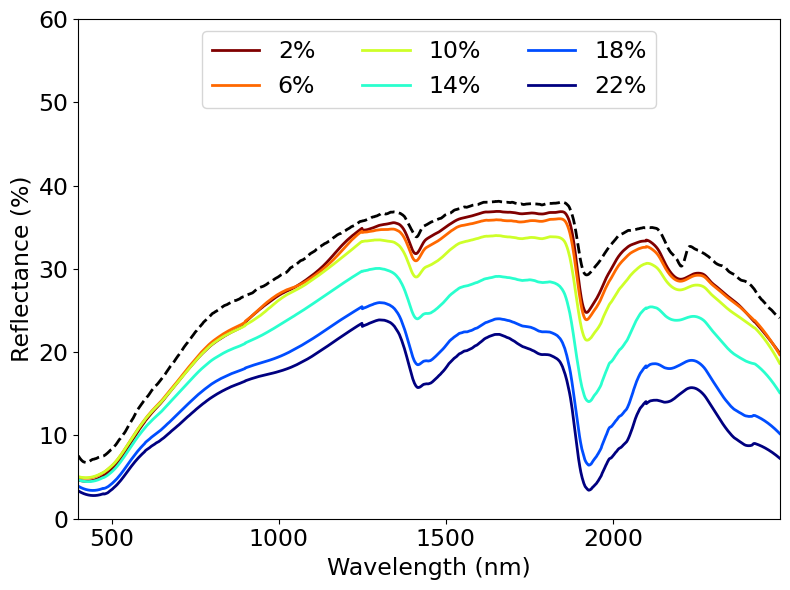

In [36]:
# plot dry and wet spectra
x_limit = (400, 2500)
y_limit = (0, 60)
x_label = 'Wavelength (nm)'
y_label = 'Reflectance (%)'
fontsz = 17

# Colors
colors = cm.jet(np.linspace(0, 1, len(SMCs_show)))  # Colormap

plt.figure(figsize=(8, 6))

# Plot each SMC level with a color from the colormap
for i, smc in enumerate(SMCs_show):
    plt.plot(wavelength, 100 * wet_spectra[i].cpu(), color=colors[-1 - i], linewidth=2)

# Plot spectratest data
plt.plot(wavelength, 100 * spectratest.T, 'black', linestyle='--', linewidth=2)

# Plot settings
plt.xlabel(x_label, fontsize=fontsz)
plt.ylabel(y_label, fontsize=fontsz)
plt.legend([f'{smc}%' for smc in SMCs_show], fontsize=fontsz, loc='upper center', ncol=3)
plt.xlim(x_limit)
plt.ylim(y_limit)
plt.xticks([500, 1000, 1500, 2000], fontsize=fontsz)
plt.yticks(fontsize=fontsz)
plt.tight_layout()

# Save the plot as an image file
# plt.savefig('results/spectraSMCs.jpeg', format='jpeg', dpi=300)  # dpi is optional, for resolution adjustment
plt.show()
# plt.close()  # Close the figure

# Run spectra padding model

(0.0, 50.0)

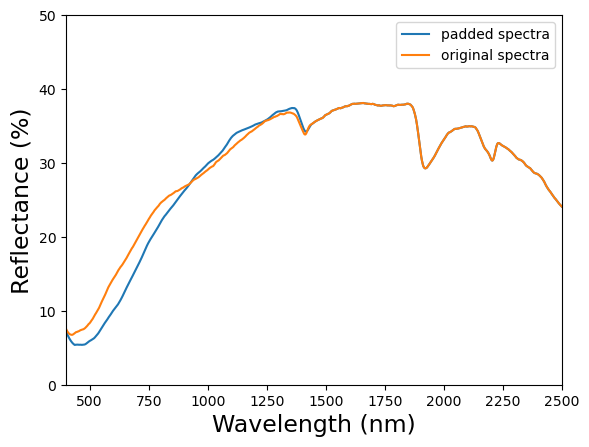

In [37]:
# set part of the test spectra to 0
spectra_test_part = torch.tensor(spectratest).float().repeat(1, 1)
spectra_test_part[:, :1000] = 0
spectra_test_fill = PS.padspectra(spectra_test_part,'cpu')
plt.plot(wavelength,100*spectra_test_fill[:, :].T)
plt.plot(wavelength,100*spectratest[:, :].T)
plt.legend(['padded spectra', 'original spectra'])
x_limit = (400, 2500)
y_limit = (0, 50)
x_label = 'Wavelength (nm)'
y_label = 'Reflectance (%)'
fontsz = 17
plt.xlabel(x_label, fontsize=fontsz)
plt.ylabel(y_label, fontsize=fontsz)
plt.xlim(x_limit)
plt.ylim(y_limit)

# Combine PROSAIL model

(0.0, 60.0)

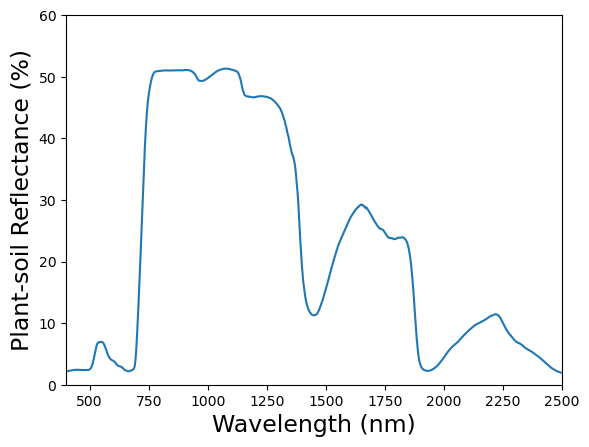

In [38]:
wet_spectrum = wet_spectra[0].cpu().numpy()
rr = prosail.run_prosail(wet_spectrum,1.5, 40., 8., 0.0, 0.01, 0.009, 3., -0.35, 0.01, 30., 10., 0.)
plt.plot(wavelength,100*rr[:-1])
x_limit = (400, 2500)
y_limit = (0, 60)
x_label = 'Wavelength (nm)'
y_label = 'Plant-soil Reflectance (%)'
fontsz = 17
plt.xlabel(x_label, fontsize=fontsz)
plt.ylabel(y_label, fontsize=fontsz)
plt.xlim(x_limit)
plt.ylim(y_limit)